In [2]:
!pip install rogue

In [13]:
## for data
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for analysis
import re
import nltk
import contractions

## for machine learning
from sklearn import preprocessing, model_selection, feature_extraction, feature_selection, metrics, manifold, naive_bayes, pipeline
from sklearn.model_selection import train_test_split

## for deep learning
from tensorflow.keras import callbacks, models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

## for W2V and textRank
import gensim
import gensim.downloader as gensim_api

## for summarization
#import rouge
import difflib

## for time
import time

In [2]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    print("Physical Devices : {}".format(tf.config.list_physical_devices()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0
Physical Devices : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-03-31 16:52:17.821096: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 16:52:23.864034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 30998 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0
2023-03-31 16:52:23.898129: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 30998 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


<h2> Data Reading and Preprocessing </h2>

In [3]:
#FUNCTION TO CREATE STOP WORDS
def create_stopwords(lst_langs=["english"], lst_add_words=[], lst_keep_words=[]):
    lst_stopwords = set()
    for lang in lst_langs:
        lst_stopwords = lst_stopwords.union( set(nltk.corpus.stopwords.words(lang)) )
    lst_stopwords = lst_stopwords.union(lst_add_words)
    lst_stopwords = list(set(lst_stopwords) - set(lst_keep_words))
    return sorted(list(set(lst_stopwords)))

In [4]:
lst_stopwords = create_stopwords()
print(len(lst_stopwords))

179


In [5]:
df = pd.read_csv("Wikipedia-Level-4-Articles.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df

,Title,Article,Category,Summary
0,Masaccio,"Masaccio (UK: , US: , Italian: [maˈzattʃo]; De...",People,"Masaccio (UK: , US: , Italian: [maˈzattʃo]; De..."
1,Hokusai,"Katsushika Hokusai (葛飾 北斎, c. 31 October 1760 ...",People,"Katsushika Hokusai (葛飾 北斎, c. 31 October 1760 ..."
2,Steven Spielberg,"Steven Allan Spielberg (; born December 18, 1...",People,"Steven Allan Spielberg (; born December 18, 1..."
3,Che Guevara,"Ernesto ""Che"" Guevara (Spanish: [ˈtʃe ɣeˈβaɾa]...",People,"Ernesto ""Che"" Guevara (Spanish: [ˈtʃe ɣeˈβaɾa]..."
4,Jöns Jacob Berzelius,Baron Jöns Jacob Berzelius (Swedish: [jœns ˈjɑ...,People,Baron Jöns Jacob Berzelius (Swedish: [jœns ˈjɑ...
...,...,...,...,...
10004,Zimbabwe,"Zimbabwe (), officially the Republic of Zimbab...",Geography,"Zimbabwe (), officially the Republic of Zimbab..."
10005,Nile,The Nile is a major north-flowing river in nor...,Geography,The Nile is a major north-flowing river in nor...
10006,Republic of Ireland,"Ireland (Irish: Éire [ˈeːɾʲə] (listen)), also ...",Geography,"Ireland (Irish: Éire [ˈeːɾʲə] (listen)), also ..."
10007,Lake Erie,"Lake Erie ( ""eerie"") is the fourth largest lak...",Geography,"Lake Erie ( ""eerie"") is the fourth largest lak..."


In [6]:
#FUNCTION TO CLEAN THE TEXT

def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
    
def utils_preprocess_text(txt, lst_regex=None, punkt=True, lower=True, slang=True, lst_stopwords=None, stemm=False, lemm=True):
    ## Regex (in case, before cleaning)
    if lst_regex is not None: 
        for regex in lst_regex:
            txt = re.sub(regex, '', txt)

    ## Clean 
    ### separate sentences with '. '
    txt = re.sub(r'\.(?=[^ \W\d])', '. ', str(txt))
    ### remove punctuations and characters
    txt = re.sub(r'[^\w\s]', '', txt) if punkt is True else txt
    ### strip
    txt = " ".join([word.strip() for word in txt.split()])
    ### lowercase
    txt = txt.lower() if lower is True else txt
    ### slang
    txt = contractions.fix(txt) if slang is True else txt
            
    ## Tokenize (convert from string to list)
    lst_txt = txt.split()
                
    ## Stemming (remove -ing, -ly, ...)
    if stemm is True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_txt = [ps.stem(word) for word in lst_txt]
                
    ## Lemmatization (convert the word into root word)
    if lemm is True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_txt = [lem.lemmatize(word) for word in lst_txt]

    ## Stopwords
    if lst_stopwords is not None:
        lst_txt = [word for word in lst_txt if word not in lst_stopwords]
        
    lst_txt = [ word for word in lst_txt if isEnglish(word) is True]
    
    # remove words less than three letters
    lst_txt = [word for word in lst_txt if len(word) >= 3]
            
    ## Back to string
    txt = " ".join(lst_txt)
    return txt



#FUNCTION TO ADD A COLUMN CONTAINING THE CLEANED TEXT
def add_preprocessed_text(data, column, lst_regex=None, punkt=False, lower=False, slang=False, lst_stopwords=None, stemm=False, lemm=True, remove_na=True):
    dtf = data.copy()

    ## apply preprocess
    dtf = dtf[ pd.notnull(dtf[column]) ]
    dtf[column+"_clean"] = dtf[column].apply(lambda x: utils_preprocess_text(x, lst_regex, punkt, lower, slang, lst_stopwords, stemm, lemm))
    
    ## residuals
    dtf["check"] = dtf[column+"_clean"].apply(lambda x: len(x))
    if dtf["check"].min() == 0:
        print("--- found NAs ---")
        print(dtf[[column,column+"_clean"]][dtf["check"]==0].head())
        if remove_na is True:
            dtf = dtf[dtf["check"]>0] 
            
    return dtf.drop("check", axis=1)

In [7]:
print("Starting to clean the Articles")
start = time.time()
df_cleaned = add_preprocessed_text(df, column="Article", 
                            punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, lemm=True,stemm=True)
end = time.time()
print("Time take to clean the Articles : {}".format(end-start))


Starting to clean the Articles
Time take to clean the Articles : 860.2032513618469


In [8]:
print("Starting to clean the Summary")
start = time.time()
df_cleaned = add_preprocessed_text(df_cleaned, column="Summary", 
                            punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, lemm=True)
end = time.time()
print("Time take to clean the Summary : {}".format(end-start))


Starting to clean the Summary
Time take to clean the Summary : 12.686798572540283


In [9]:
df_cleaned

,Title,Article,Category,Summary,Article_clean,Summary_clean
0,Masaccio,"Masaccio (UK: , US: , Italian: [maˈzattʃo]; De...",People,"Masaccio (UK: , US: , Italian: [maˈzattʃo]; De...",masaccio italian decemb 1401 summer 1428 born ...,masaccio italian december 1401 summer 1428 bor...
1,Hokusai,"Katsushika Hokusai (葛飾 北斎, c. 31 October 1760 ...",People,"Katsushika Hokusai (葛飾 北斎, c. 31 October 1760 ...",katsushika hokusai octob 1760 may 1849 known s...,katsushika hokusai october 1760 may 1849 known...
2,Steven Spielberg,"Steven Allan Spielberg (; born December 18, 1...",People,"Steven Allan Spielberg (; born December 18, 1...",steven allan spielberg born decemb 1946 americ...,steven allan spielberg born december 1946 amer...
3,Che Guevara,"Ernesto ""Che"" Guevara (Spanish: [ˈtʃe ɣeˈβaɾa]...",People,"Ernesto ""Che"" Guevara (Spanish: [ˈtʃe ɣeˈβaɾa]...",ernesto che guevara spanish june 1928 octob 19...,ernesto che guevara spanish june 1928 october ...
4,Jöns Jacob Berzelius,Baron Jöns Jacob Berzelius (Swedish: [jœns ˈjɑ...,People,Baron Jöns Jacob Berzelius (Swedish: [jœns ˈjɑ...,baron jacob berzeliu swedish contemporari name...,baron jacob berzelius swedish contemporary nam...
...,...,...,...,...,...,...
10004,Zimbabwe,"Zimbabwe (), officially the Republic of Zimbab...",Geography,"Zimbabwe (), officially the Republic of Zimbab...",zimbabw offici republ zimbabw landlock countri...,zimbabwe officially republic zimbabwe landlock...
10005,Nile,The Nile is a major north-flowing river in nor...,Geography,The Nile is a major north-flowing river in nor...,nile major northflow river northeastern africa...,nile major northflowing river northeastern afr...
10006,Republic of Ireland,"Ireland (Irish: Éire [ˈeːɾʲə] (listen)), also ...",Geography,"Ireland (Irish: Éire [ˈeːɾʲə] (listen)), also ...",ireland irish listen also known republ ireland...,ireland irish listen also known republic irela...
10007,Lake Erie,"Lake Erie ( ""eerie"") is the fourth largest lak...",Geography,"Lake Erie ( ""eerie"") is the fourth largest lak...",lake eri eeri fourth largest lake surfac area ...,lake erie eerie fourth largest lake surface ar...


In [10]:
df_cleaned.to_csv("Wikipedia-Level-4-Articles-Cleaned-2.csv")

<h2>Cleaned DF</h2>

In [14]:
df_cleaned = pd.read_csv("Wikipedia-Level-4-Articles-Cleaned-1.csv")

# Define the categories you want to select
categories = ["People", "Arts", "History", "Biology_and_health_sciences", "Everyday_life", "Geography", "Philosophy_and_religion", "Society_and_social_sciences"]

# Create an empty list to store the selected rows
selected_rows = []

# Loop through each category and select 30 rows
for category in categories:
    category_rows = df_cleaned[df_cleaned["Category"] == category].head(200)
    selected_rows.append(category_rows)

# Concatenate all the selected rows into a new dataframe
df_cleaned = pd.concat(selected_rows)

In [15]:
df_cleaned

,Unnamed: 0,Title,Article,Category,Summary,Article_clean,Summary_clean
0,0,Masaccio,"Masaccio (UK: , US: , Italian: [maˈzattʃo]; De...",People,"Masaccio (UK: , US: , Italian: [maˈzattʃo]; De...",masaccio uk u italian december 21 1401 summer ...,masaccio uk u italian december 21 1401 summer ...
1,1,Hokusai,"Katsushika Hokusai (葛飾 北斎, c. 31 October 1760 ...",People,"Katsushika Hokusai (葛飾 北斎, c. 31 October 1760 ...",katsushika hokusai c 31 october 1760 10 may 18...,katsushika hokusai c 31 october 1760 10 may 18...
2,2,Steven Spielberg,"Steven Allan Spielberg (; born December 18, 1...",People,"Steven Allan Spielberg (; born December 18, 1...",steven allan spielberg born december 18 1946 a...,steven allan spielberg born december 18 1946 a...
3,3,Che Guevara,"Ernesto ""Che"" Guevara (Spanish: [ˈtʃe ɣeˈβaɾa]...",People,"Ernesto ""Che"" Guevara (Spanish: [ˈtʃe ɣeˈβaɾa]...",ernesto che guevara spanish 14 june 1928 9 oct...,ernesto che guevara spanish 14 june 1928 9 oct...
4,4,Jöns Jacob Berzelius,Baron Jöns Jacob Berzelius (Swedish: [jœns ˈjɑ...,People,Baron Jöns Jacob Berzelius (Swedish: [jœns ˈjɑ...,baron jacob berzelius swedish contemporary nam...,baron jacob berzelius swedish contemporary nam...
...,...,...,...,...,...,...,...
10004,10004,Zimbabwe,"Zimbabwe (), officially the Republic of Zimbab...",Geography,"Zimbabwe (), officially the Republic of Zimbab...",zimbabwe officially republic zimbabwe landlock...,zimbabwe officially republic zimbabwe landlock...
10005,10005,Nile,The Nile is a major north-flowing river in nor...,Geography,The Nile is a major north-flowing river in nor...,nile major northflowing river northeastern afr...,nile major northflowing river northeastern afr...
10006,10006,Republic of Ireland,"Ireland (Irish: Éire [ˈeːɾʲə] (listen)), also ...",Geography,"Ireland (Irish: Éire [ˈeːɾʲə] (listen)), also ...",ireland irish listen also known republic irela...,ireland irish listen also known republic irela...
10007,10007,Lake Erie,"Lake Erie ( ""eerie"") is the fourth largest lak...",Geography,"Lake Erie ( ""eerie"") is the fourth largest lak...",lake erie eerie fourth largest lake surface ar...,lake erie eerie fourth largest lake surface ar...


<h2> Exploratory Data Analysis </h2>

In [16]:
#FUNCTION TO CREATE THE WORD FREQUENCIES
def word_freq(corpus, ngrams=[1,2,3], top=10, figsize=(10,7)):
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    ngrams = [ngrams] if type(ngrams) is int else ngrams
    
    ## calculate
    dtf_freq = pd.DataFrame()
    for n in ngrams:
        dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
        dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=["word","freq"])
        dtf_n["ngrams"] = n
        dtf_freq = dtf_freq.append(dtf_n)
    dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
    dtf_freq = dtf_freq.sort_values(["ngrams","freq"], ascending=[True,False])
    
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax,
                data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(top))
    ax.set(xlabel=None, ylabel=None, title="Most frequent words")
    ax.grid(axis="x")
    plt.show()
    return dtf_freq

Finding out the most frequent words in Articles


IOStream.flush timed out


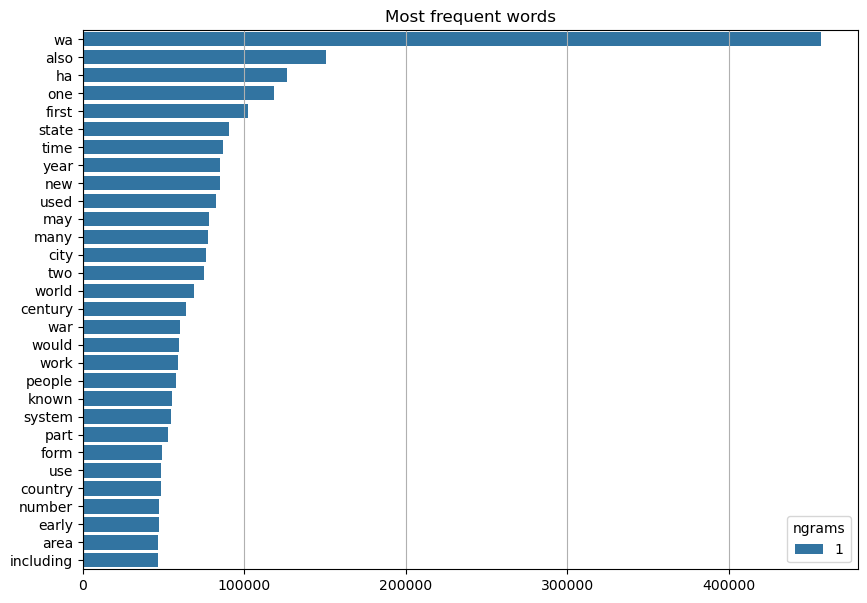

Time taken to find most frequent words in Articles : 120.40030884742737


In [17]:
print("Finding out the most frequent words in Articles")
start = time.time()
df_frequency = word_freq(corpus=df_cleaned["Article_clean"], ngrams=[1], top=30, figsize=(10,7))
end = time.time()
print("Time taken to find most frequent words in Articles : {}".format(end-start))

In [18]:
thres = 20
X_top_words = len(df_frequency[df_frequency["freq"]>thres])
X_top_words

58390

Finding out the most frequent words in Summaries


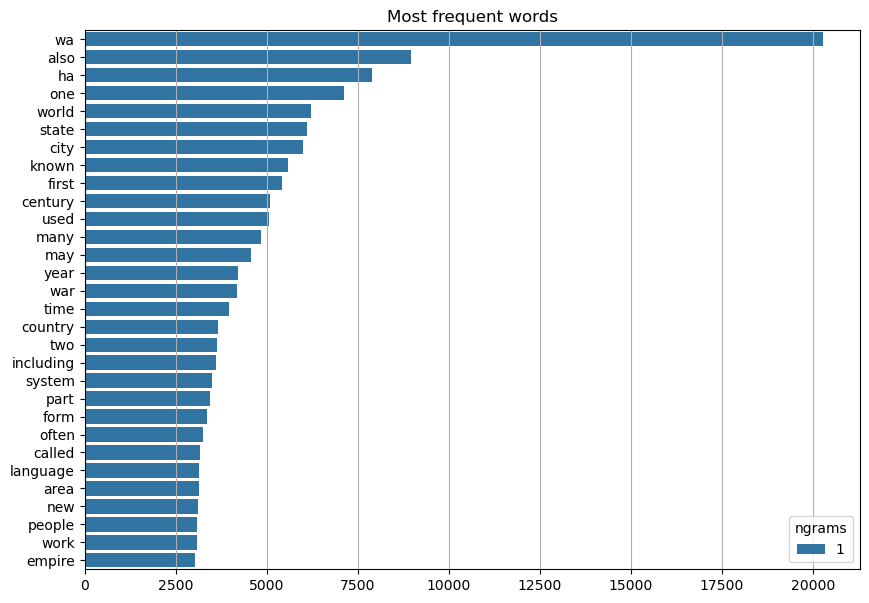

Time taken to find most frequent words in Summaries : 7.987321615219116


In [19]:
print("Finding out the most frequent words in Summaries")
start = time.time()
df_frequency = word_freq(corpus=df_cleaned["Summary_clean"], ngrams=[1], top=30, figsize=(10,7))
end = time.time()
print("Time taken to find most frequent words in Summaries : {}".format(end-start))

In [20]:
thres = 20
Y_top_words = len(df_frequency[df_frequency["freq"]>thres])
Y_top_words

9494

In [21]:
#FUNCTION TO FIND THE STATISTICS ABOUT THE SENTENCE LENGTH
def add_text_length(data, column):
    dtf = data.copy()
    dtf['word_count'] = dtf[column].apply(lambda x: len(nltk.word_tokenize(str(x))) )
    dtf['char_count'] = dtf[column].apply(lambda x: sum(len(word) for word in nltk.word_tokenize(str(x))) )
    dtf['sentence_count'] = dtf[column].apply(lambda x: len(nltk.sent_tokenize(str(x))) )
    dtf['avg_word_length'] = dtf['char_count'] / dtf['word_count']
    dtf['avg_sentence_lenght'] = dtf['word_count'] / dtf['sentence_count']
    print(dtf[['char_count','word_count','sentence_count','avg_word_length','avg_sentence_lenght']].describe().T[["min","mean","max"]])
    return dtf

In [22]:
X = add_text_length(df_cleaned, "Article_clean")

                           min          mean            max
char_count           507.00000  22530.357478  147579.000000
word_count            61.00000   3487.168548   22149.000000
sentence_count         1.00000      1.000000       1.000000
avg_word_length        4.75629      6.465148       8.713689
avg_sentence_lenght   61.00000   3487.168548   22149.000000


In [23]:
Y = add_text_length(df_cleaned, "Summary_clean")

                           min         mean          max
char_count           43.000000  1127.172445  7561.000000
word_count            9.000000   171.217105  1183.000000
sentence_count        1.000000     1.000000     1.000000
avg_word_length       4.611111     6.592787     9.322581
avg_sentence_lenght   9.000000   171.217105  1183.000000


In [24]:
def plot_distributions(dtf, x, max_cat=20, top=None, y=None, bins=None, figsize=(10,5)):
    ## univariate
    if y is None:
        fig, ax = plt.subplots(figsize=figsize)
        fig.suptitle(x, fontsize=15)
        ### categorical
        if dtf[x].nunique() <= max_cat:
            if top is None:
                dtf[x].reset_index().groupby(x).count().sort_values(by="index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
            else:   
                dtf[x].reset_index().groupby(x).count().sort_values(by="index").tail(top).plot(kind="barh", legend=False, ax=ax).grid(axis='x')
            ax.set(ylabel=None)
        ### numerical
        else:
            sns.distplot(dtf[x], hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
            ax.grid(True)
            ax.set(xlabel=None, yticklabels=[], yticks=[])

    ## bivariate
    else:
        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=figsize)
        fig.suptitle(x, fontsize=15)
        for i in dtf[y].unique():
            sns.distplot(dtf[dtf[y]==i][x], hist=True, kde=False, bins=bins, hist_kws={"alpha":0.8}, axlabel="", ax=ax[0])
            sns.distplot(dtf[dtf[y]==i][x], hist=False, kde=True, kde_kws={"shade":True}, axlabel="", ax=ax[1])
        ax[0].set(title="histogram")
        ax[0].grid(True)
        ax[0].legend(dtf[y].unique())
        ax[1].set(title="density")
        ax[1].grid(True)
    plt.show()

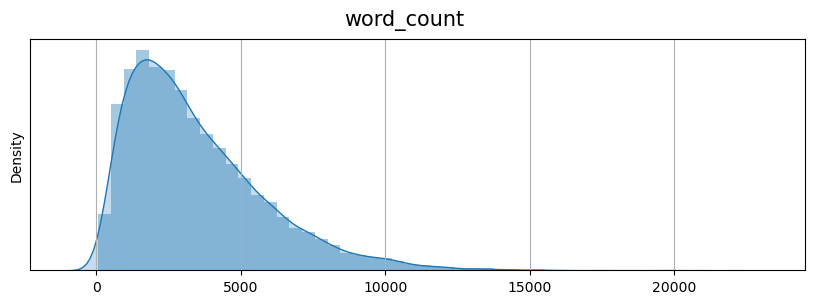

In [25]:
plot_distributions(X, x="word_count", figsize=(10,3))

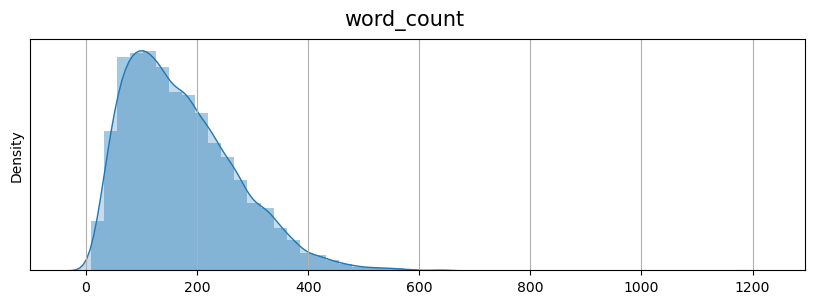

In [26]:
plot_distributions(Y, x="word_count", figsize=(10,3))

<h2> Preprocessing (Train-Test Split) </h2>

In [27]:
x_train, x_test, y_train, y_test = train_test_split( df_cleaned["Article_clean"], df_cleaned["Summary_clean"], test_size = 0.2 , random_state = 42)
x_train = pd.DataFrame(x_train, columns = ["Article_clean"])
x_test = pd.DataFrame(x_test, columns = ["Article_clean"])
y_train = pd.DataFrame(y_train, columns = ["Summary_clean"])
y_test = pd.DataFrame(y_test, columns = ["Summary_clean"])

In [28]:
len(x_train.iloc[0]["Article_clean"])

7846

In [29]:
len(y_train.iloc[0]["Summary_clean"])

371

In [30]:
#FUNCTION TO CREATE NGRAMS
def utils_preprocess_ngrams(corpus, ngrams=1, grams_join=" ", lst_ngrams_detectors=[]):
    ## create list of n-grams
    lst_corpus = []
    for string in corpus:
        lst_words = string.split()
        lst_grams = [grams_join.join(lst_words[i:i + ngrams]) for i in range(0, len(lst_words), ngrams)]
        lst_corpus.append(lst_grams)
    
    ## detect common bi-grams and tri-grams
    if len(lst_ngrams_detectors) != 0:
        for detector in lst_ngrams_detectors:
            lst_corpus = list(detector[lst_corpus])
    return lst_corpus


In [31]:
#FUNCTION TO CREATE TOKENIZED TEXT WITH SAME PADDING
def text2seq(corpus, ngrams=1, grams_join=" ", lst_ngrams_detectors=[], fitted_tokenizer=None, top=None, oov=None, maxlen=None, padding="<PAD>"):    
    print("--- tokenization ---")
    
    ## detect common n-grams in corpus
    lst_corpus = utils_preprocess_ngrams(corpus, ngrams=ngrams, grams_join=grams_join, lst_ngrams_detectors=lst_ngrams_detectors)

    ## bow with keras to get text2tokens without creating the sparse matrix
    ### train
    if fitted_tokenizer is None:
        tokenizer = kprocessing.text.Tokenizer(num_words=top, lower=False, split=' ', char_level=False, oov_token=oov,
                                               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
        tokenizer.fit_on_texts(lst_corpus)
        dic_vocabulary = {padding:0}
        words = tokenizer.word_index if top is None else dict(list(tokenizer.word_index.items())[0:top+1])
        dic_vocabulary.update(words)
        print(len(dic_vocabulary), "words")
    else:
        tokenizer = fitted_tokenizer
    ### transform
    lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

    ## padding sequence (from [1,2],[3,4,5,6] to [0,0,1,2],[3,4,5,6])
    print("--- padding to sequence ---")
    X = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=maxlen, padding="post", truncating="post")
    print(X.shape[0], "sequences of length", X.shape[1]) 

    ## plot heatmap
    fig, ax = plt.subplots(figsize=(15,5))
    sns.heatmap(X==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title('Sequences Overview')
    plt.show()
    return {"X":X, "tokenizer":tokenizer, "dic_vocabulary":dic_vocabulary} if fitted_tokenizer is None else X


<h3> Creating the paddings for Cleaned Articles </h3>

In [32]:
X_len = 6800
Y_len = 350

--- tokenization ---
58392 words
--- padding to sequence ---
8007 sequences of length 6800


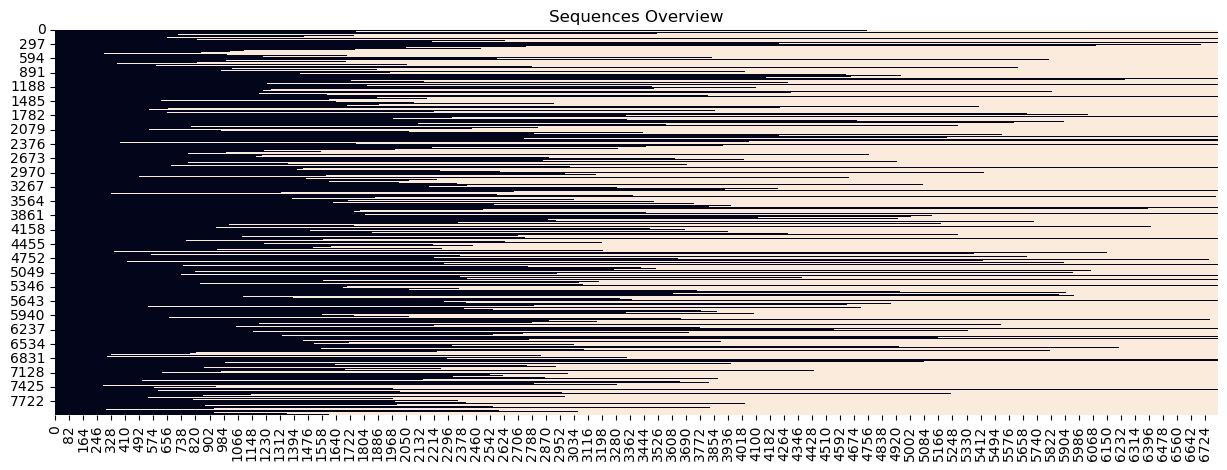

In [33]:
dic_seq = text2seq(corpus=x_train["Article_clean"], top=X_top_words, maxlen=X_len)

In [34]:
X_train = dic_seq["X"] 
X_tokenizer = dic_seq["tokenizer"] 
X_dic_vocabulary = dic_seq["dic_vocabulary"]

--- tokenization ---
--- padding to sequence ---
2002 sequences of length 6800


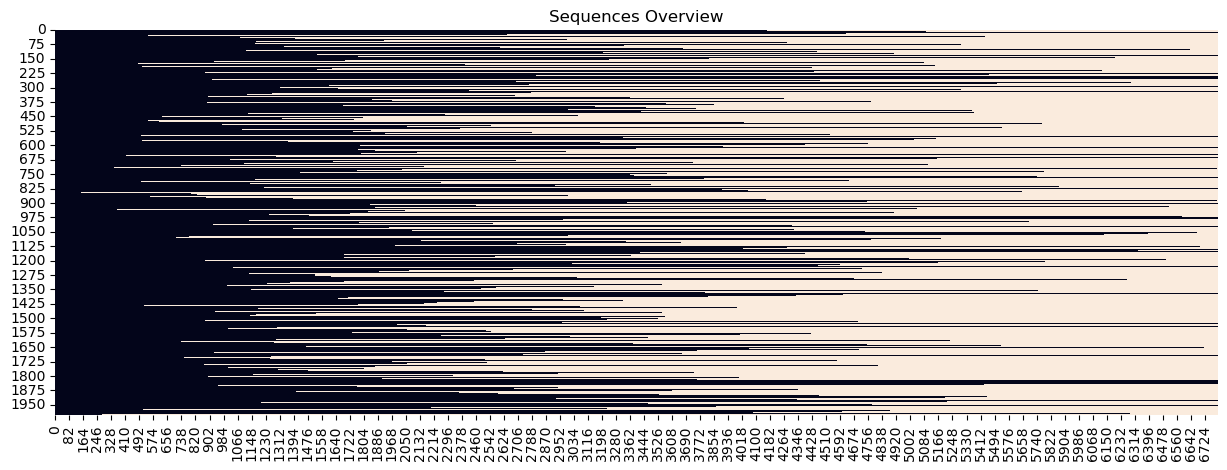

In [35]:
X_test = text2seq(corpus=x_test["Article_clean"], fitted_tokenizer=X_tokenizer, maxlen=X_train.shape[1])

<h3> Creating the paddings for Cleaned Summaries </h3>

In [36]:
y_train["Summary_clean"] = y_train["Summary_clean"].astype('str') 
y_test["Summary_clean"] = y_test["Summary_clean"].astype('str') 

In [37]:
print(y_train["Summary_clean"].isna().any())
print(y_test["Summary_clean"].isna().any())

False
False


In [38]:
y_train.dtypes

Summary_clean    object
dtype: object

In [39]:
y_test.dtypes

Summary_clean    object
dtype: object

In [40]:
y_train.iloc[0]["Summary_clean"]

'fiber fibre latin fibra natural artificial substance significantly longer wide fiber often used manufacture material strongest engineering material often incorporate fiber example carbon fiber ultrahighmolecularweight polyethylene synthetic fiber often produced cheaply large amount compared natural fiber clothing natural fiber give benefit comfort synthetic counterpart'

In [41]:
special_tokens = ("<START>", "<END>")
y_train["Summary_clean"] = y_train['Summary_clean'].apply(lambda x: special_tokens[0]+' '+x+' '+special_tokens[1])
y_test["Summary_clean"] = y_test['Summary_clean'].apply(lambda x: special_tokens[0]+' '+x+' '+special_tokens[1])


--- tokenization ---
9496 words
--- padding to sequence ---
8007 sequences of length 350


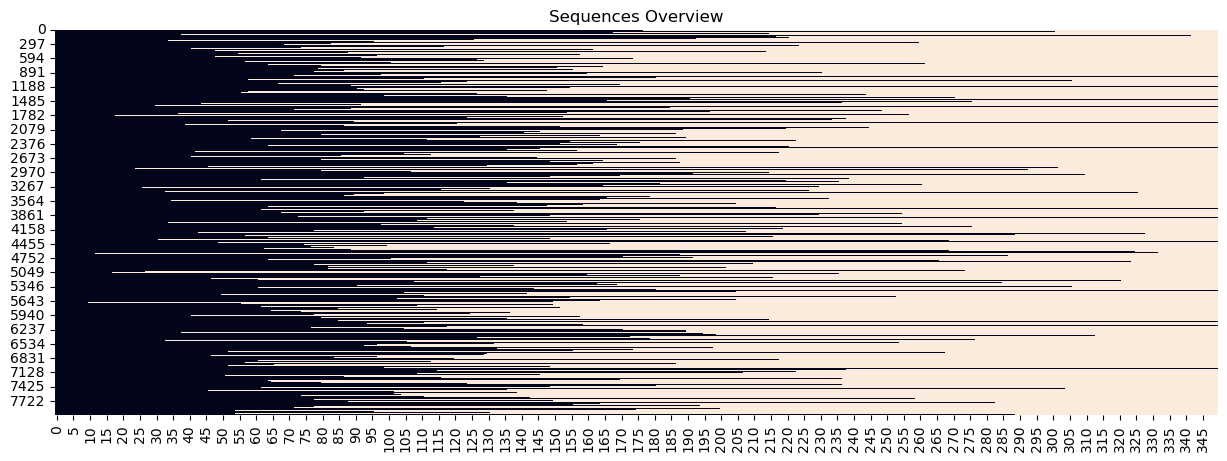

In [42]:
dic_seq = text2seq(corpus=y_train["Summary_clean"], top=Y_top_words, maxlen=Y_len)

In [43]:
Y_train = dic_seq["X"] 
Y_tokenizer = dic_seq["tokenizer"] 
Y_dic_vocabulary = dic_seq["dic_vocabulary"]

--- tokenization ---
--- padding to sequence ---
2002 sequences of length 350


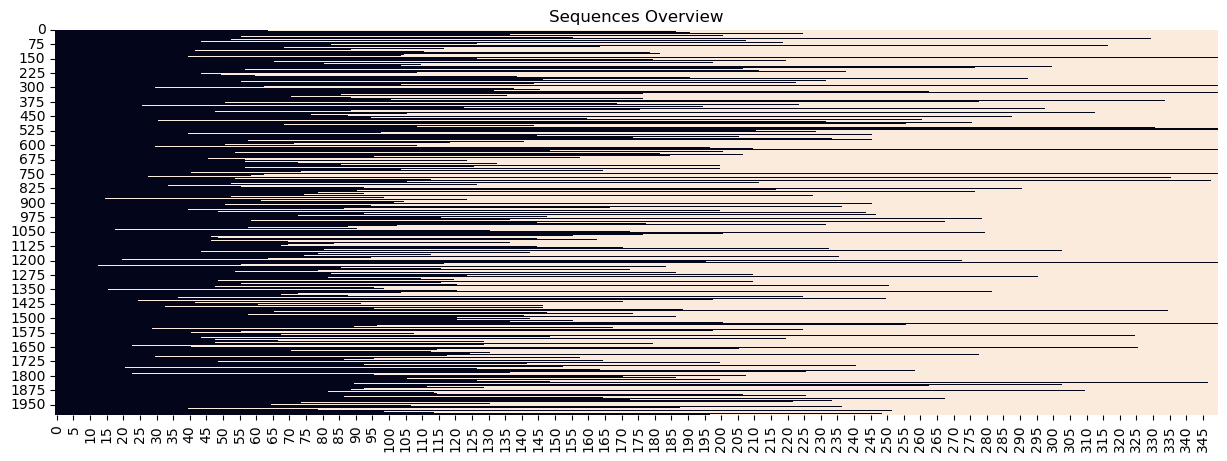

In [44]:
Y_test = text2seq(corpus=y_test["Summary_clean"], fitted_tokenizer=Y_tokenizer, maxlen=Y_train.shape[1])

<h2> Creating Word Embeddings(GloVe) using GENSIM </h2>

In [45]:
import gensim.downloader as api

In [46]:
nlp = api.load('glove-wiki-gigaword-300')

In [47]:
#FUNCTION TO MAP THE WORDS IN THE VOCABULARY TO THEIR RESPECTIVE WORD EMBEDDINGS
def vocabulary_embeddings(dic_vocabulary, nlp=None):
    nlp = gensim_api.load("glove-wiki-gigaword-300") if nlp is None else nlp
    embeddings = np.zeros((len(dic_vocabulary)+1, nlp.vector_size))
    for word,idx in dic_vocabulary.items():
        ## update the row with vector
        try:
            embeddings[idx] =  nlp[word]
        ## if word not in model then skip and the row stays all zeros
        except:
            pass
    print("vocabulary mapped to", embeddings.shape[0], "vectors of size", embeddings.shape[1])
    return embeddings

In [48]:
X_embeddings = vocabulary_embeddings(X_dic_vocabulary, nlp)
X_embeddings.shape

vocabulary mapped to 58393 vectors of size 300


(58393, 300)

In [49]:
Y_embeddings = vocabulary_embeddings(Y_dic_vocabulary, nlp)
Y_embeddings.shape

vocabulary mapped to 9497 vectors of size 300


(9497, 300)

<h2> Model Building </h2>

<h3> BBC Model </h3>

In [50]:
K.clear_session() 

In [57]:
from keras import backend as K 
K.clear_session() 
latent_dim = 128
embedding_dim=300
# Encoder 
encoder_inputs = Input(shape=(X_len,)) 
enc_emb =  Embedding(len(X_embeddings), embedding_dim,trainable=True,weights=[X_embeddings])(encoder_inputs)

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.5) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.5) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.5) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(len(Y_dic_vocabulary), embedding_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.5) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

attention =Attention()
attn_out = attention([decoder_outputs,encoder_outputs])

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(len(Y_dic_vocabulary), activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6800)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 6800, 300)    17517900    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 6800, 128),  219648      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [58]:
#Used to compile the model using adam as optimizer

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [59]:
#It will stop the training of the model whenever validation los is not changing for 4 epochs.

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=4)

In [60]:
history=model.fit([X_train,Y_train[:,:-1]], Y_train.reshape(Y_train.shape[0],Y_train.shape[1], 1)[:,1:] ,epochs=15,callbacks=[es],batch_size=128, validation_data=([X_test,Y_test[:,:-1]], Y_test.reshape(Y_test.shape[0],Y_test.shape[1], 1)[:,1:]))

2023-03-31 21:10:46.380641: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2023-03-31 21:10:50.019593: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla V100-SXM2-32GB" frequency: 1530 num_cores: 80 environment { key: "architecture" value: "7.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 98304 memory_size: 32503955456 bandwidth: 898048000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-03-31 21:10:50.313134: I tensorflow/stream_executor/cuda/cuda_driver.cc:732] failed to allocate 29.43G (31599928576 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-03-31 21:10:50.317776: I tensorflow/stream_executor/cuda/cuda_driver.cc:732] failed to allocate 29.43G (31599928576 bytes) fr

KeyboardInterrupt: 

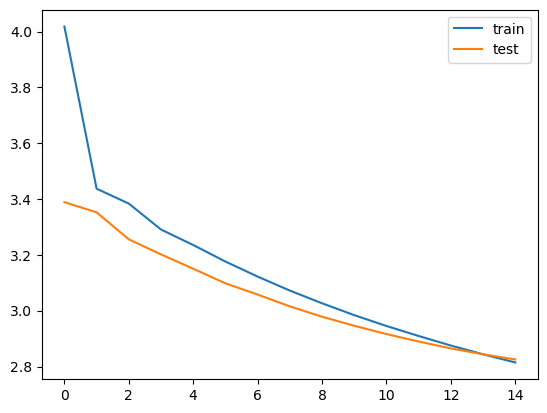

In [103]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [104]:
reverse_target_word_index=Y_tokenizer.index_word 
reverse_source_word_index=X_tokenizer.index_word 
target_word_index=Y_tokenizer.word_index

In [105]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(X_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf = attention([decoder_outputs2,decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [106]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6800)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 6800, 300)         17517600  
_________________________________________________________________
lstm (LSTM)                  [(None, 6800, 128), (None 219648    
_________________________________________________________________
lstm_1 (LSTM)                [(None, 6800, 128), (None 131584    
_________________________________________________________________
lstm_2 (LSTM)                [(None, 6800, 128), (None 131584    
Total params: 18,000,416
Trainable params: 18,000,416
Non-trainable params: 0
_________________________________________________________________


In [107]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    2848800     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
____________________________________________________________________________________________

In [108]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['<START>']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index in reverse_target_word_index:
            sampled_token = reverse_target_word_index[sampled_token_index]
        else:
            sampled_token = "<UNKNOWN>"
        
        if(sampled_token!="<END>"):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == "<END>"  or len(decoded_sentence.split()) >= (Y_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c
        
        print(decoded_sentence)

    return decoded_sentence

In [109]:
def seq2summary(input_seq):
    String=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        String=String+reverse_target_word_index[i]+' '
    return String

def seq2text(input_seq):
    String=''
    for i in input_seq:
      if(i!=0):
        String=String+reverse_source_word_index[i]+' '
    return String

In [110]:
decode_sequence(X_train[1].reshape(1,X_len))

2023-03-31 00:30:24.819147: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla V100-SXM2-32GB" frequency: 1530 num_cores: 80 environment { key: "architecture" value: "7.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 98304 memory_size: 32503955456 bandwidth: 898048000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


 also
 also known
 also known also
 also known also known
 also known also known english
 also known also known english english
 also known also known english english english
 also known also known english english english english
 also known also known english english english english english
 also known also known english english english english english english
 also known also known english english english english english english english
 also known also known english english english english english english english english
 also known also known english english english english english english english english english
 also known also known english english english english english english english english english english
 also known also known english english english english english english english english english english english
 also known also known english english english english english english english english english english english english
 also known also known english english eng

KeyboardInterrupt: 

In [91]:
for i in range(1,5):
    #print("Review:",seq2text(X_train[i]))
    #print("Original summary:",seq2summary(Y_train[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_len_text)))
    # print("\n")

Original summary: <START> johannes dutch listen internationally known johan cruyff 25 april 1947 24 march 2016 wa dutch professional football player manager player ballon dor three time 1971 1973 1974 cruyff wa proponent football philosophy known total football explored generally regarded one influential figure modern football considered one best player greatest manager history sport late 1960s early 1970s dutch football rose obscure level become powerhouse sport cruyff led netherlands final 1974 fifa world cup three goal three assist received golden ball player tournament finishing third uefa euro 1976 cruyff refused play 1978 fifa world cup kidnapping attempt targeting family barcelona home football club level cruyff started career eight title three european cup one cup two assist final match scored goal provided 170 assist 1973 moved barcelona world record transfer fee helping team win la liga first season winning ballon dor 180 official match barcelona scored 60 goal provided 83 as

<h3> Basic Model </h3>

In [136]:
# Basic Seq2Seq
lstm_units = 250
embeddings_size = 300

##------------ ENCODER (embeddings + lstm) -----------------------------##
x_in = layers.Input(name="x_in", shape=(X_train.shape[1],))
### embeddi/ng
layer_x_emb = layers.Embedding(name="x_emb", input_dim=len(X_dic_vocabulary), output_dim=embeddings_size, 
                               trainable=True)
x_emb = layer_x_emb(x_in)
### lstm 
layer_x_lstm = layers.LSTM(name="x_lstm", units=lstm_units, dropout=0.4,  
                           return_sequences=True, return_state=True)
x_out, state_h, state_c = layer_x_lstm(x_emb)

##------------ DECODER (embeddings + lstm + dense) ---------------------##
y_in = layers.Input(name="y_in", shape=(None,))
### embedding
layer_y_emb = layers.Embedding(name="y_emb", input_dim=len(Y_dic_vocabulary), output_dim=embeddings_size, 
                               trainable=True)
y_emb = layer_y_emb(y_in)
### lstm 
layer_y_lstm = layers.LSTM(name="y_lstm", units=lstm_units, dropout=0.4,
                           return_sequences=True, return_state=True)
y_out, _, _ = layer_y_lstm(y_emb, initial_state=[state_h, state_c])
### final dense layers
layer_dense = layers.TimeDistributed(name="dense", 
                                     layer=layers.Dense(units=len(Y_dic_vocabulary), activation='softmax'))
y_out = layer_dense(y_out)

##---------------------------- COMPILE --------------------------------##
model = models.Model(inputs=[x_in, y_in], outputs=y_out, name="Seq2Seq-Simple-1")
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "Seq2Seq-Simple-1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_in (InputLayer)               [(None, 9000)]       0                                            
__________________________________________________________________________________________________
y_in (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
x_emb (Embedding)               (None, 9000, 300)    27121800    x_in[0][0]                       
__________________________________________________________________________________________________
y_emb (Embedding)               (None, None, 300)    4362900     y_in[0][0]                       
___________________________________________________________________________________

In [137]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model =models. Model(inputs=x_in, outputs=[x_out, state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = layers.Input(shape=(lstm_units, ))
decoder_state_input_c = layers.Input(shape=(lstm_units, ))
decoder_hidden_state_input = layers.Input(shape=(X_train.shape[1], lstm_units))

# Get the embeddings of the decoder sequence
dec_emb2 = layer_y_emb(y_in)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = layer_y_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = layer_dense(decoder_outputs2)

# Final decoder model
decoder_model = models.Model([y_in] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [138]:
encoder_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x_in (InputLayer)            [(None, 9000)]            0         
_________________________________________________________________
x_emb (Embedding)            (None, 9000, 300)         27121800  
_________________________________________________________________
x_lstm (LSTM)                [(None, 9000, 250), (None 551000    
Total params: 27,672,800
Trainable params: 27,672,800
Non-trainable params: 0
_________________________________________________________________


In [139]:
decoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
y_in (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
y_emb (Embedding)               (None, None, 300)    4362900     y_in[0][0]                       
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 250)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 250)]        0                                            
____________________________________________________________________________________________

lstm_units = lstm_units*2 if any("Bidirectional" in str(layer) for layer in model.layers) else lstm_units
### encoder

encoder_model = models.Model(inputs=x_in, outputs=[x_out, state_h, state_c], name="Prediction_Encoder")
### decoder

encoder_out = layers.Input(shape=(X_train.shape[1], lstm_units))
state_h, state_c = layers.Input(shape=(lstm_units,)), layers.Input(shape=(lstm_units,))
y_emb2 = layer_y_emb(y_in)
y_out2, new_state_h, new_state_c = layer_y_lstm(y_emb2, initial_state=[state_h, state_c])
predicted_prob = layer_dense(y_out2) 
decoder_model = models.Model(inputs=[y_in, encoder_out, state_h, state_c], 
                             outputs=[predicted_prob, new_state_h, new_state_c], 
                             name="Prediction_Decoder")

In [ ]:
batch_size = 128
epochs = 30
verbose = 1

In [ ]:
K.clear_session()
training = model.fit(x=[X_train, Y_train[:,:-1]], 
                         y=Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)[:,1:],
                         batch_size=batch_size, epochs=epochs, shuffle=True, verbose=verbose, validation_split=0.3,
                         callbacks=[callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)])

2023-03-29 15:07:38.624943: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-03-29 15:07:41.499329: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100


20/20 [==============================] - 32s 1s/step - loss: 5.3589 - accuracy: 0.5781 - val_loss: 3.6875 - val_accuracy: 0.6180
Epoch 2/30
20/20 [==============================] - 27s 1s/step - loss: 3.6138 - accuracy: 0.6088 - val_loss: 3.3186 - val_accuracy: 0.6180
Epoch 3/30
20/20 [==============================] - 27s 1s/step - loss: 3.3386 - accuracy: 0.6091 - val_loss: 3.2602 - val_accuracy: 0.6187
Epoch 4/30
20/20 [==============================] - 27s 1s/step - loss: 3.2999 - accuracy: 0.6108 - val_loss: 3.2517 - val_accuracy: 0.6200
Epoch 5/30
20/20 [==============================] - 27s 1s/step - loss: 3.2790 - accuracy: 0.6129 - val_loss: 3.2347 - val_accuracy: 0.6226
Epoch 6/30
20/20 [==============================] - 27s 1s/step - loss: 3.2606 - accuracy: 0.6137 - val_loss: 3.2274 - val_accuracy: 0.6228
Epoch 7/30
20/20 [==============================] - 27s 1s/step - loss: 3.2353 - accuracy: 0.6138 - val_loss: 3.2067 - val_accuracy: 0.6231
Epoch 8/30
20/20 [=============

In [55]:
training

In [57]:
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

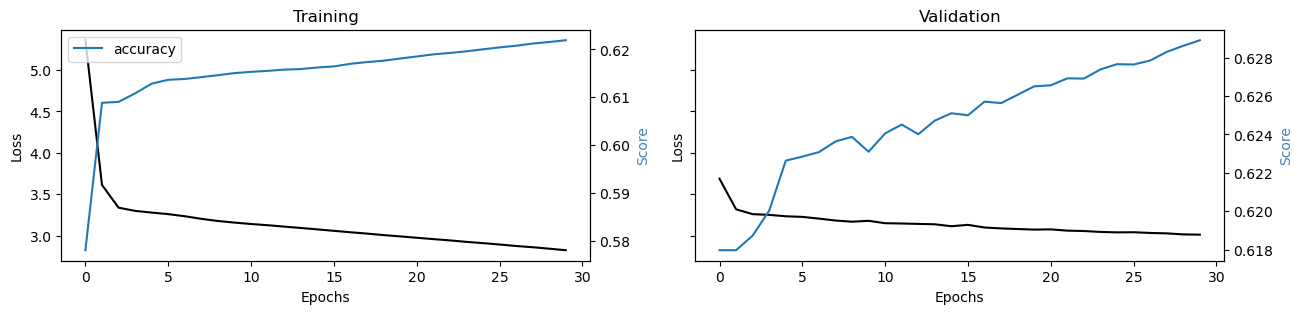

In [58]:
utils_plot_keras_training(training)

In [60]:
reverse_target_word_index = Y_tokenizer.index_word
reverse_source_word_index = X_tokenizer.index_word
target_word_index = Y_tokenizer.word_index


In [67]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['<START>']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != '<END>':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == '<END>' or len(decoded_sentence.split()) \
            >= Y_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)
        
        print(decoded_sentence)

    return decoded_sentence

In [61]:
model.save('very-simple-model-3',save_format='h5')

In [68]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['<START>'] and i \
            != target_word_index['<END>']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [ ]:
for i in range(0, 19):
    #print ('Review:', seq2text(X_train[i]))

    print ('Original summary:', seq2summary(Y_train[i]))
    print ('Predicted summary:', decode_sequence(X_train[i].reshape(1,
           X_len)))
    print ('\n')

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [59]:
def predict_seq2seq(X_test, encoder_model, decoder_model, fitted_tokenizer, special_tokens=("<START>","<END>")):
    max_seq_length = 100
    predicted = []
    for x in X_test:
        x = x.reshape(1,-1)

        ## encode X
        x_out, state_h, state_c = encoder_model.predict(x)

        ## prepare loop
        y_in = np.array([fitted_tokenizer.word_index[special_tokens[0]]])
        predicted_text = ""
        stop = False

        while not stop:
            ## predict dictionary probability distribution
            probs, new_state_h, new_state_c = decoder_model.predict([y_in, x_out, state_h, state_c])
            ## get predicted word
            voc_idx = np.argmax(probs[0,-1,:])
            pred_word = fitted_tokenizer.index_word[voc_idx]
            ## check stop
            if (pred_word != special_tokens[1]) or (len(predicted_text.split()) < max_seq_length):
                predicted_text = predicted_text +" "+ pred_word
                #print(predicted_text)
            else:
                stop = True
            ## next
            y_in = np.array([voc_idx])
            state_h, state_c = new_state_h, new_state_c

        predicted_text = predicted_text.replace(special_tokens[0],"").strip()
        print(predicted_text)
        predicted.append(predicted_text)
        

    return predicted

In [61]:
predicted = predict_seq2seq(X_test[:5], encoder_model, decoder_model, Y_tokenizer, special_tokens)

KeyboardInterrupt: 

In [ ]:
def evaluate_summary(y_test, predicted):
    rouge_score = rouge.Rouge()
    scores = rouge_score.get_scores(y_test, predicted, avg=True)
    score_1 = round(scores['rouge-1']['f'], 2)
    score_2 = round(scores['rouge-2']['f'], 2)
    score_L = round(scores['rouge-l']['f'], 2)
    print("rouge1:", score_1, "| rouge2:", score_2, "| rougeL:", score_2, 
          "--> avg rouge:", round(np.mean([score_1,score_2,score_L]), 2))

<h3> Advanced Model </h3>

In [47]:
# Advanced Seq2Seq
lstm_units = 250

##------------ ENCODER (pre-trained embeddings + 3 bi-lstm) ---------------##
x_in = layers.Input(name="x_in", shape=(X_train.shape[1],))
### embedding
layer_x_emb = layers.Embedding(name="x_emb", input_dim=X_embeddings.shape[0], output_dim=X_embeddings.shape[1], 
                               weights=[X_embeddings], trainable=False)
x_emb = layer_x_emb(x_in)
### bi-lstm 1
layer_x_bilstm = layers.Bidirectional(layers.LSTM(units=lstm_units, dropout=0.4, recurrent_dropout=0.4,
                                                  return_sequences=True, return_state=True), 
                                      name="x_lstm_1")
x_out, _, _, _, _ = layer_x_bilstm(x_emb)
### bi-lstm 2
layer_x_bilstm = layers.Bidirectional(layers.LSTM(units=lstm_units, dropout=0.4, recurrent_dropout=0.4,
                                                  return_sequences=True, return_state=True),
                                      name="x_lstm_2")
x_out, _, _, _, _ = layer_x_bilstm(x_out)
### bi-lstm 3 (here final states are collected)
layer_x_bilstm = layers.Bidirectional(layers.LSTM(units=lstm_units, dropout=0.4, recurrent_dropout=0.4, 
                                                  return_sequences=True, return_state=True),
                                      name="x_lstm_3")
x_out, forward_h, forward_c, backward_h, backward_c = layer_x_bilstm(x_out)
state_h = layers.Concatenate()([forward_h, backward_h])
state_c = layers.Concatenate()([forward_c, backward_c])

##------------ DECODER (pre-trained embeddings + lstm + dense) ------------##
y_in = layers.Input(name="y_in", shape=(None,))
### embedding
layer_y_emb = layers.Embedding(name="y_emb", input_dim=Y_embeddings.shape[0], output_dim=Y_embeddings.shape[1], 
                               weights=[Y_embeddings], trainable=False)
y_emb = layer_y_emb(y_in)
### lstm
layer_y_lstm = layers.LSTM(name="y_lstm", units=lstm_units*2, dropout=0.2, recurrent_dropout=0.2,
                           return_sequences=True, return_state=True)
y_out, _, _ = layer_y_lstm(y_emb, initial_state=[state_h, state_c])
### final dense layers
layer_dense = layers.TimeDistributed(name="dense", 
                                     layer=layers.Dense(units=len(Y_dic_vocabulary), activation='softmax'))
y_out = layer_dense(y_out)

##---------------------------- COMPILE ------------------------------------##
model = models.Model(inputs=[x_in, y_in], outputs=y_out, name="Seq2Seq")
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

model.summary()

Model: "Seq2Seq"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_in (InputLayer)               [(None, 9000)]       0                                            
__________________________________________________________________________________________________
x_emb (Embedding)               (None, 9000, 300)    41902800    x_in[0][0]                       
__________________________________________________________________________________________________
x_lstm_1 (Bidirectional)        [(None, 9000, 500),  1102000     x_emb[0][0]                      
__________________________________________________________________________________________________
x_lstm_2 (Bidirectional)        [(None, 9000, 500),  1502000     x_lstm_1[0][0]                   
____________________________________________________________________________________________

In [41]:
lstm_units = lstm_units*2 if any("Bidirectional" in str(layer) for layer in model.layers) else lstm_units
### encoder

encoder_model = models.Model(inputs=x_in, outputs=[x_out, state_h, state_c], name="Prediction_Encoder")
### decoder

encoder_out = layers.Input(shape=(X_train.shape[1], lstm_units))
state_h, state_c = layers.Input(shape=(lstm_units,)), layers.Input(shape=(lstm_units,))
y_emb2 = layer_y_emb(y_in)
y_out2, new_state_h, new_state_c = layer_y_lstm(y_emb2, initial_state=[state_h, state_c])
predicted_prob = layer_dense(y_out2) 
decoder_model = models.Model(inputs=[y_in, encoder_out, state_h, state_c], 
                             outputs=[predicted_prob, new_state_h, new_state_c], 
                             name="Prediction_Decoder")

In [42]:
encoder_model.summary()

Model: "Prediction_Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_in (InputLayer)               [(None, 9000)]       0                                            
__________________________________________________________________________________________________
x_emb (Embedding)               (None, 9000, 300)    41902800    x_in[0][0]                       
__________________________________________________________________________________________________
x_lstm_1 (Bidirectional)        [(None, 9000, 500),  1102000     x_emb[0][0]                      
__________________________________________________________________________________________________
x_lstm_2 (Bidirectional)        [(None, 9000, 500),  1502000     x_lstm_1[0][0]                   
_________________________________________________________________________________

In [43]:
decoder_model.summary()

Model: "Prediction_Decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
y_in (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
y_emb (Embedding)               (None, None, 300)    6561600     y_in[0][0]                       
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 500)]        0                                            
_________________________________________________________________________________

In [44]:
batch_size = 128
epochs = 30
verbose = 1

In [ ]:
K.clear_session()
training = model.fit(x=[X_train, Y_train[:,:-1]], 
                         y=Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)[:,1:],
                         batch_size=batch_size, epochs=epochs, shuffle=True, verbose=verbose, validation_split=0.3,
                         callbacks=[callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)])

In [143]:
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

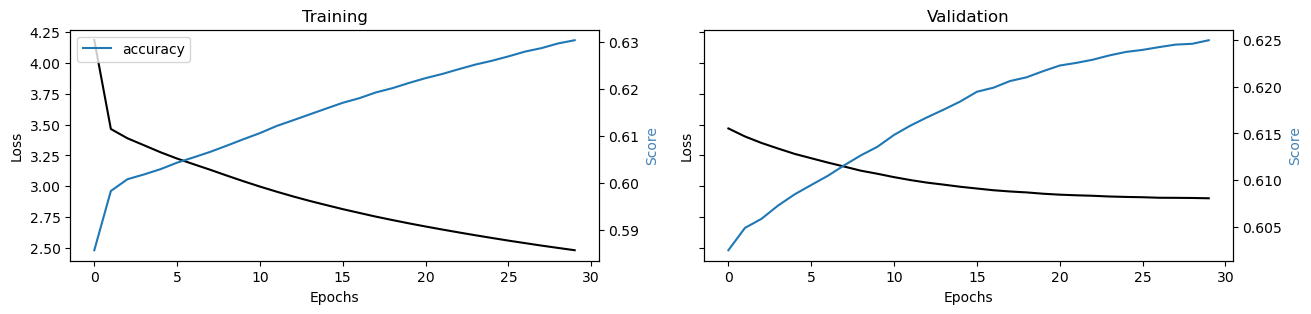

In [144]:
utils_plot_keras_training(training)

In [ ]:
model.save('very-simple-model-1',save_format='h5')

In [65]:
encoder_model.summary()

Model: "Prediction_Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x_in (InputLayer)            [(None, 1600)]            0         
_________________________________________________________________
x_emb (Embedding)            (None, 1600, 300)         41902500  
_________________________________________________________________
x_lstm (LSTM)                [(None, 1600, 250), (None 551000    
Total params: 42,453,500
Trainable params: 42,453,500
Non-trainable params: 0
_________________________________________________________________


In [66]:
decoder_model.summary()

Model: "Prediction_Decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
y_in (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
y_emb (Embedding)               (None, None, 300)    6561300     y_in[0][0]                       
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 250)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 250)]        0                                            
_________________________________________________________________________________

In [ ]:
def predict_seq2seq(X_test, encoder_model, decoder_model, fitted_tokenizer, special_tokens=("<START>","<END>")):
    max_seq_length = Y_len
    predicted = []
    for x in X_test:
        x = x.reshape(1,-1)

        ## encode X
        x_out, state_h, state_c = encoder_model.predict(x)

        ## prepare loop
        y_in = np.array([fitted_tokenizer.word_index[special_tokens[0]]])
        predicted_text = ""
        stop = False

        while not stop:
            ## predict dictionary probability distribution
            probs, new_state_h, new_state_c = decoder_model.predict([y_in, x_out, state_h, state_c])
            ## get predicted word
            voc_idx = np.argmax(probs[0,-1,:])
            pred_word = fitted_tokenizer.index_word[voc_idx]
            ## check stop
            if (pred_word != special_tokens[1]) or (len(predicted_text.split()) < max_seq_length):
                predicted_text = predicted_text +" "+ pred_word
                print(predicted_text)
            else:
                stop = True
            ## next
            y_in = np.array([voc_idx])
            state_h, state_c = new_state_h, new_state_c

        predicted_text = predicted_text.replace(special_tokens[0],"").strip()
        predicted.append(predicted_text)
        

    return predicted

In [ ]:
predicted = predict_seq2seq(X_test, encoder_model, decoder_model, Y_tokenizer, special_tokens)

In [ ]:
def evaluate_summary(y_test, predicted):
    rouge_score = rouge.Rouge()
    scores = rouge_score.get_scores(y_test, predicted, avg=True)
    score_1 = round(scores['rouge-1']['f'], 2)
    score_2 = round(scores['rouge-2']['f'], 2)
    score_L = round(scores['rouge-l']['f'], 2)
    print("rouge1:", score_1, "| rouge2:", score_2, "| rougeL:", score_2, 
          "--> avg rouge:", round(np.mean([score_1,score_2,score_L]), 2))